<a href="https://colab.research.google.com/github/HenrySomeCode/DCGAN_fake_handwritten_digits_tensorflow/blob/main/DCGAN_fake_handwritten_digits_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [ ]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

In [3]:
from tensorflow.keras import layers

In [4]:
import matplotlib.pyplot as plt

In [5]:
import os

In [6]:
import time

In [7]:
from IPython import display

In [8]:
tf.__version__

'2.12.0'

In [9]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [10]:
train_images.shape

(60000, 28, 28)

In [11]:
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images.shape

(60000, 28, 28, 1)

In [ ]:
train_images

In [13]:
# normalize the images to [-1,1] 
train_images = (train_images-127.5) / 127.5 

In [14]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
next(iter(train_dataset))

Creating the generator model

In [17]:
def generator_model():
  model = tf.keras.Sequential()
  # noise vector (100) => dense layer (7*7*256) => batch-norm + leaky-relu
  model.add(layers.Dense(7*7*256, use_bias = False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  
  #vector (7*7*256) => reshape: (7,7,256) 
  model.add(layers.Reshape((7,7,256)))
  # 'assert' keyword is used for debugging, it helps check if a condition in the code returns True,
  # if not, the program will raise an AssertionError or a custom message
  # learn about assert at https://www.w3schools.com/python/ref_keyword_assert.asp 
  assert model.output_shape == (None, 7,7, 256) # None is for batch-size, which means no batch here

  # tensor (7,7,256) => transposed conv: (7,7,128) => batch-norm + leaky-relu
  # Transpoed-conv formula: W_out = (W_in-1)*S-2P+F with S: Stride, F: Filter, P: padding
  # for padding = 'same' : "With 'SAME' padding, padding is applied to each spatial dimension. 
  # When the strides are 1, the input is padded such that the output size is the same as the input size"
  # [Souce : https://www.tensorflow.org/api_docs/python/tf/nn#notes_on_padding_2 ] 
  # Actually, my opinion is that, in tensorflow, the output height and width
  # depend only on input width & height and stride. More specifically, 
  # out_height = in_height * strides[1]
  # out_width  = in_width * strides[2]
  # the padding size is computed from here to make the transposed convolution products
  # the above height and weight so:
  # padding_height = [strides[1] * (in_height - 1) + kernel_size[0] - out_height] / 2
  # padding_width  = [[strides[2] * (in_width - 1) + kernel_size[1] - out_width] / 2
  # [Source: https://python.plainenglish.io/how-to-calculate-the-output-size-when-using-conv2dtranspose-layer-19124c79aa15 ]
  model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
  assert model.output_shape == (None,7,7,128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # tensor (7,7,128) => transposed-conv: (14,14,64) => batch-norm + leaky-relu
  # In my case, the input weight and height is (7,7), output is (7*2,7*2) so 
  # padding weight and height is 1.5. For this, the top padding is 1 and bottom padding is 2
  # the left padding is 1 and right padding is 2
  # [Source: https://python.plainenglish.io/how-to-calculate-the-output-size-when-using-conv2dtranspose-layer-19124c79aa15 ]
  model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
  assert model.output_shape == (None,14,14,64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  #tensor (14,14,64) => transposed-conv: (28,28,1) => tanh
  model.add(layers.Conv2DTranspose(1,(5,5), strides=(2,2), padding='same', use_bias = False, activation = 'tanh'))
  assert model.output_shape == (None, 28,28,1)

  return model


In [18]:
generator = generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

Make a noise vector

In [ ]:
#generate a noise vector that contains random values from a normal distribution
noise = tf.random.normal([1,100])
noise

Test the generator model with a noise vector

In [20]:
generated_image = generator(noise, training=False)

In [21]:
generated_image.shape

TensorShape([1, 28, 28, 1])

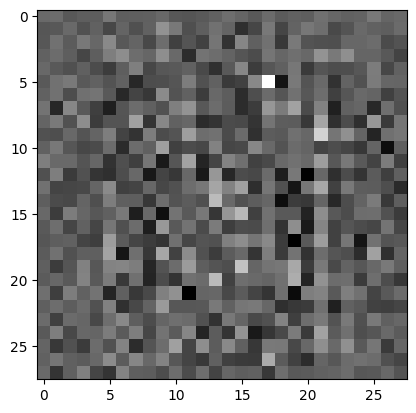

In [22]:
plt.imshow(generated_image[0,:,:,:], cmap='gray')

Creating the discriminator model

In [23]:
def discrimninator_model ():
  model = tf.keras.Sequential()
  # tensor (28,28,1) => conv: (14,14,64) => leaky-relu + dropout. Why doesn't this discriminator use batch-norm ?  
  # conv formula: W_out = (W_in+2P-F)/S + 1
  model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  #tensor (14,14,64) => conv: (7,7,128) => leaky-relu + dropout
  model.add(layers.Conv2D(128,(5,5), strides=(2,2), padding ='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  #flatten => dense
  model.add(layers.Flatten())
  model.add(layers.Dense(1)) # I think that I can use conv2d + sigmoid at here instead, like here: https://colab.research.google.com/drive/1ONvWiF1E--n2hxehS01VccVYPqwhxW1a?usp=sharing 

  return model

In [24]:
discriminator = discrimninator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

Test with images generated by generator model 

In [25]:
predictions = discriminator(generated_image)
predictions

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.0011222]], dtype=float32)>

Define discriminator & generator model's loss funnctions and optimizers

In [26]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
def discriminator_loss(real_output, fake_output):
  #real output is the output of discriminator model when input is real, same goes for fake_output
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss 

In [28]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [29]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [30]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [31]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [32]:
seed.shape

TensorShape([16, 100])

In [33]:
 # make function runs faster by creates a graph. By that, simplifing the computations and find 
 # opportuanities for parallelization.
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images,training = True )

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    
  gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [34]:
def train(dataset, epochs):
  #in each epoch => in each batch =>...
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)

    if(epoch+1) % 15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    
    print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [37]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:,:]*127.5+127.5, cmap='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

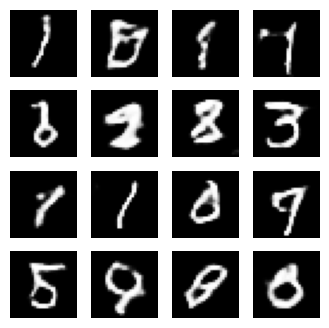

In [38]:
train(train_dataset, EPOCHS)

In [39]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [40]:
import PIL

In [41]:
import imageio

In [42]:
import glob

In [43]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04}.png'.format(epoch_no))

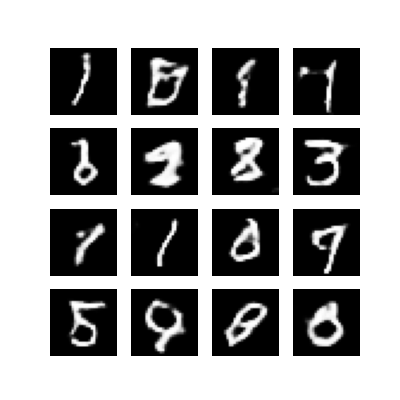

In [44]:
display_image(EPOCHS)

In [47]:
anim_file = 'dcgan.gif'

In [ ]:
filenames = glob.glob('image*.png')
filenames

In [ ]:
#model 'I' means model for multiple images
with imageio.get_writer(anim_file, mode ='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
      image = imageio.imread(filename)
      writer.append_data(image)
  
  image = imageio.imread(filename)
  writer.append_data(image)

In [49]:
import tensorflow_docs.vis.embed as embed


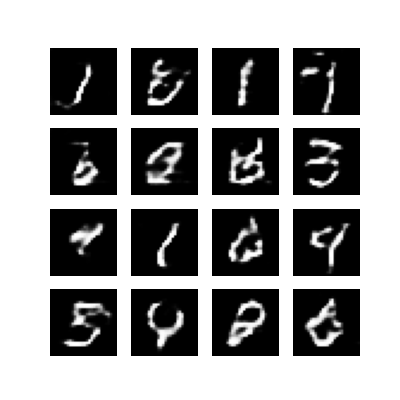

In [50]:
embed.embed_file(anim_file)